In [27]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [28]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


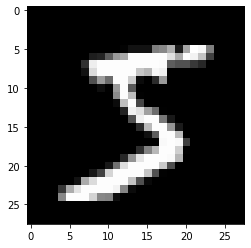

In [29]:
# 각 이미지는 28 x 28이고 길이가 784(=28x28)인 평평한 행으로 저장

from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [30]:
# pytorch는 numpy array가 아닌, tensor를 사용하므로 변환하는 과정이 필요함
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [31]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [32]:
# 활성화 함수
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

# @ = 내적 연산의미 >> 하나의 데이터 batch에 대해 (64개의 이미지) 함수 호출 = 하나의 순전파, 그러나 랜덤 가중치로 시작
def model(xb):
    return log_softmax(xb @ weights + bias)

In [33]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.0993, -2.1785, -2.4725, -2.1213, -2.1400, -2.3175, -2.6665, -2.3199,
        -2.6187, -2.2715], grad_fn=<SelectBackward>) torch.Size([64, 10])


`preds` 텐서는 텐서 값 뿐만 아니라 그래디언트 함수도 포함되었다. 해당 값은 이후 역전파 때 사용된다.

In [34]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [35]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3817, grad_fn=<NegBackward>)


In [36]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.0938)


### train

In [37]:
from IPython.core.debugger import set_trace

lr = 0.5 
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace() # 해당 line에서 프로그램 실행 중단 및 디버깅 세션 시작
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [38]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0809, grad_fn=<NegBackward>) tensor(1.)


### torch.nn.functional
코드 리팩토링

In [39]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [40]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>) tensor(1.)


### nn.Module
코드 리팩토링

In [41]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

In [42]:
# 메소드가 아니라 객체를 사용하므로 변수에 할당하여 인스턴스화 해야함

model = Mnist_Logistic()

In [43]:
print(loss_func(model(xb), yb))

tensor(2.3049, grad_fn=<NllLossBackward>)


In [45]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

In [44]:
# with torch.no_grad():
#     for p in model.parameters(): p -= p.grad * lr
#     model.zero_grad()

TypeError: ignored

In [46]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

In [47]:
print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)


### nn.Linear
코드 리팩토링

In [48]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

In [49]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3926, grad_fn=<NllLossBackward>)


In [ ]:
fit()
print(loss_func(model(xb), yb))

### Optimize
코드 리팩토링

```
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()
```
해당 코드 대신 사용
```
opt.step()
opt.zero_grad()
```

In [51]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2705, grad_fn=<NllLossBackward>)
tensor(0.0829, grad_fn=<NllLossBackward>)


### Dataset
리팩토링  

PyTorch의 TensorDataset은 텐서를 래핑하는 Dataset으로, 인덱싱의 길이와 방법을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스하는 방법도 제공합니다. 이렇게 하면 우리가 훈련할 때 같은 줄에 있는 독립 변수와 종속 변수에 더 쉽게 액세스할 수 있음

In [52]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)

model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0806, grad_fn=<NllLossBackward>)


### DataLoader
리팩터링  
`train_ds[i*bs : i*bs+bs]` : 미니 배치를 자동으로 제공
```

In [59]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [60]:
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)

In [61]:
for xb,yb in train_dl:
    pred = model(xb)

In [62]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0827, grad_fn=<NllLossBackward>)


### 유효성 검사
과적합 여부를 식별하기 위함   
역전파를 필요로 하지 않으므로 그라디언트를 저장할 필요가 없음

In [63]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [64]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3220)
1 tensor(0.3250)


### fit() & get_data()

In [65]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [66]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [67]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [68]:
# 훈련 및 검증 세트에 대한 데이터 로더 반환
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [69]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.30166370120048525
1 0.29150945115089416


### CNN

In [70]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

In [71]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.337031063747406
1 0.24675275948047637


### nn.Sequential

In [72]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [73]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.4441887287378311
1 0.26338076120615006


### DataLoader 래핑

In [74]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [75]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [76]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.34839188566207885
1 0.319659298825264


### GPU 사용

In [77]:
print(torch.cuda.is_available())

False


In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

 - **torch.nn**

   + ``Module``: 함수처럼 작동하지만 상태(예: 신경망 레이어 가중치)를 포함할 수도 있는 호출 가능을 생성합니다. 무엇 Parameter을 포함 하는지 알고 있으며 모든 그라디언트를 0으로 만들고 가중치 업데이트 등을 위해 루프를 반복할 수 있습니다.
   + ``Parameter``: 역전파 동안 업데이트 해야하는 가중치가 있음을 알려주는 텐서의 래퍼 (require_grad 세트가 업데이트)
   + ``functional``
 - ``torch.optim``: 후진 단계에서 의 SGD가중치를 업데이트하는 와 같은 옵티마이저가 포함
 - ``Dataset``: Pytorch에서 제공하는 클래스를 포함한 객체의 추상 인터페이스
 - ``DataLoader``: Dataset데이터 배치를 반환하는 반복자를 생성